MAPE for Dataset 2: 83.76%


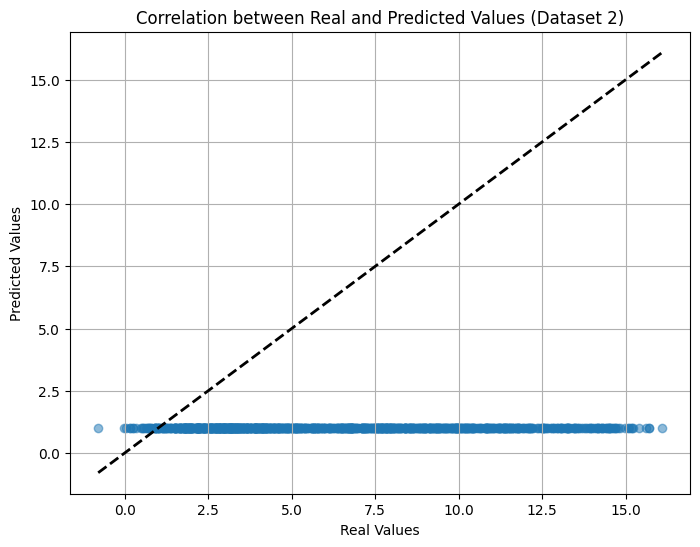

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Code for MyNeuralNetwork class and training functions
class MyNeuralNetwork:
    def __init__(self, num_layers, num_units, num_epochs, learning_rate, momentum, activation_function, validation_percentage):
        self.L = num_layers
        self.n = num_units
        self.num_epochs = num_epochs
        self.eta = learning_rate
        self.alpha = momentum
        self.fact = activation_function
        self.validation_percentage = validation_percentage
        self.xi = [np.zeros(layer_units) for layer_units in num_units]
        self.h = [np.zeros(layer_units) for layer_units in num_units]
        self.w = [None] + [np.zeros((num_units[i], num_units[i - 1])) for i in range(1, num_layers)]
        self.theta = [np.zeros(layer_units) for layer_units in num_units]
        self.delta = [np.zeros(layer_units) for layer_units in num_units]
        self.d_w = [None] + [np.zeros((num_units[i], num_units[i - 1])) for i in range(1, num_layers)]
        self.d_theta = [np.zeros(layer_units) for layer_units in num_units]
        self.d_w_prev = [None] + [np.zeros((num_units[i], num_units[i - 1])) for i in range(1, num_layers)]
        self.d_theta_prev = [np.zeros(layer_units) for layer_units in num_units]
        self.training_error = []
        self.validation_error = []

    # Sigmoid activation function
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def linear(self, x):
        return x

    def linear_derivative(self, x):
        return np.ones_like(x)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - x**2

    def activation(self, x):
        if self.fact == 'sigmoid':
            return self.sigmoid(x)
        elif self.fact == 'relu':
            return self.relu(x)
        elif self.fact == 'linear':
            return self.linear(x)
        elif self.fact == 'tanh':
            return self.tanh(x)

    def activation_derivative(self, x):
        if self.fact == 'sigmoid':
            return self.sigmoid_derivative(x)
        elif self.fact == 'relu':
            return self.relu_derivative(x)
        elif self.fact == 'linear':
            return self.linear_derivative(x)
        elif self.fact == 'tanh':
            return self.tanh_derivative(x)

    def feed_forward(self, sample):
        self.xi[0] = sample
        for l in range(1, self.L):
            self.h[l] = np.dot(self.w[l], self.xi[l - 1]) - self.theta[l]
            self.xi[l] = self.activation(self.h[l])

    def backpropagate(self, target):
        self.delta[self.L - 1] = self.activation_derivative(self.xi[self.L - 1]) * (self.xi[self.L - 1] - target)
        for l in range(self.L - 2, 0, -1):
            self.delta[l] = self.activation_derivative(self.xi[l]) * np.dot(self.w[l + 1].T, self.delta[l + 1])

    def update_weights(self):
        for l in range(1, self.L):
            self.d_w[l] = -self.eta * np.outer(self.delta[l], self.xi[l - 1]) + self.alpha * self.d_w_prev[l]
            self.d_theta[l] = self.eta * self.delta[l] + self.alpha * self.d_theta_prev[l]
            self.w[l] += self.d_w[l]
            self.theta[l] += self.d_theta[l]
            self.d_w_prev[l] = self.d_w[l]
            self.d_theta_prev[l] = self.d_theta[l]

    def calculate_total_error(self, X, y):
        total_error = 0.0
        for i in range(X.shape[0]):
            self.feed_forward(X[i])
            total_error += 0.5 * np.sum((self.xi[self.L - 1] - y[i]) ** 2)
        return total_error

    def fit(self, X, y):
        # Split data into training and validation sets
        n_samples = X.shape[0]
        if self.validation_percentage > 0:
            n_train = int(n_samples * (1.0 - self.validation_percentage))
            X_train = X[:n_train]
            y_train = y[:n_train]
            X_val = X[n_train:]
            y_val = y[n_train:]
        else:
            X_train = X
            y_train = y
            X_val = np.array([])
            y_val = np.array([])

        for epoch in range(self.num_epochs):
            for i in range(X_train.shape[0]):
                sample = X_train[i]
                target = y_train[i]

                self.feed_forward(sample)
                self.backpropagate(target)
                self.update_weights()

            # Calculate training error
            train_error = self.calculate_total_error(X_train, y_train)
            self.training_error.append(train_error)

            # Calculate validation error
            if X_val.shape[0] > 0:
                val_error = self.calculate_total_error(X_val, y_val)
                self.validation_error.append(val_error)

    def predict(self, X):
        predictions = []
        for sample in X:
            self.feed_forward(sample)
            predictions.append(self.xi[self.L - 1].copy())
        return np.array(predictions)

    # Function to retrieve epoch-wise loss data in the required format
    def get_epoch_losses(self):
        epochs = list(range(1, self.num_epochs + 1))
        return np.column_stack((epochs, self.training_error, self.validation_error))

    # Modify the loss_epochs() function to use get_epoch_losses()
    def loss_epochs(self):
        return self.get_epoch_losses()

# Function to train a neural network on a given dataset
def train_neural_network(dataset, input_columns, output_column, num_layers, num_units, num_epochs, learning_rate, momentum, activation_function, validation_percentage):
    X = dataset[input_columns].values
    y = dataset[output_column].values.reshape(-1, 1)

    nn = MyNeuralNetwork(num_layers, num_units, num_epochs, learning_rate, momentum, activation_function, validation_percentage)
    
    nn.fit(X, y)
    
    X_test = X  # You can use a different test dataset if needed
    predictions = nn.predict(X_test)

    return nn, predictions

# Function to calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

# Load the dataset
dataset2 = pd.read_csv('A1-synthetic.csv')

# Define input and output columns for dataset 2
input_columns2 = ['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9']
output_column2 = 'z'

# Neural network configurations
num_layers = 4
num_units2 = [len(input_columns2)] + [10, 5, 1]
num_epochs = 1000
learning_rate = 0.1
momentum = 0.0
activation_function = "sigmoid"
validation_percentage = 0.2

# Train the neural network for dataset 2
nn2, predictions2 = train_neural_network(dataset2, input_columns2, output_column2, num_layers, num_units2, num_epochs, learning_rate, momentum, activation_function, validation_percentage)

# Assuming predictions2 contains predicted values and dataset2 contains the real values
real_values = dataset2[output_column2].values.reshape(-1, 1)

# Calculate MAPE for dataset 2
mape2 = calculate_mape(real_values, predictions2)
print(f"MAPE for Dataset 2: {mape2:.2f}%")

# Visualize the scatter plot for dataset 2
plt.figure(figsize=(8, 6))
plt.scatter(real_values, predictions2, alpha=0.5)
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Correlation between Real and Predicted Values (Dataset 2)')
plt.grid(True)
plt.plot([real_values.min(), real_values.max()], [real_values.min(), real_values.max()], 'k--', lw=2) # diagonal line
plt.savefig('correlation_plot_dataset2.png')
plt.show()

# Save predictions to a file
np.savetxt("predictions_dataset2.csv", predictions2, delimiter=",")

# Save loss data to a file
loss_data2 = nn2.loss_epochs()
np.savetxt("loss_data_dataset2.csv", loss_data2, delimiter=",")
